# Introduction

The goal of this document is to guide the reader through the process of creating a good model for predicting on a specific data set. The data set in this case is company data which assesses the quality of the online advertisment campaign and wants to predict wheter a customer subscribes or not. 

## Imports

To assess this certain python packages are needed which are loaded below.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


# from yellowbrick.classifier import ROCAUC
# from yellowbrick.datasets import load_spam
# visualizer = ROCAUC(best_model, classes=[0, 1])
# visualizer.fit(train, y_train)
# visualizer.score(valid, y_valid)
# visualizer.show()

def plot_ROC(true, predicted):
    RocCurveDisplay.from_predictions(
        true,
        predicted,
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()



def make_confusion_matrix(cf,
                          group_names= None,
                          categories= 'auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            specificity = cf[0,0] / (cf[0,0] + cf[0,1])
            sensitivity = cf[1,1] / (cf[1,0] + cf[1,1])
            stats_text = "\n\nAccuracy={:0.3f}   Precision={:0.3f}   Recall={:0.3f}\n      F1 Score={:0.3f}   Sensitivity{:0.3f}   Specificity={:0.3f}".format(
                accuracy,precision,recall,f1_score, sensitivity,specificity)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    
    plt.show()



## Description of data set

A company wants to assess the quality of their online advertisement campaign. Online users are the main interest
in this campaign. The users see a web banner during their browsing activity. For each user, they want to be able
to predict whether they subscribe to the advertised product through the advertisement banner, based on the
information they have about them. To subscribe, the user has to click on the banner and then subscribe to the
service. The target variable name is subscription

# Exploratory data analysis (EDA) and feature engineering (FE)

In a first part we do EDA before we have a look at FE.

## EDA

First of all one needs to load the data and have a look over it. 

In [4]:
train = pd.read_csv('data/MLUnige2023_subscriptions_train.csv', index_col='Id', na_values='na', header=0)
train

,age,job,marital,education,device,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,outcome_old,X1,X2,X3,X4,subscription
Id,,,,,,,,,,,,,,,,,
0,28,freelance,married,grad_school,smartphone,4,2,26.80,3,4,196,failure,0,0,1,0.072803,1
1,48,industrial_worker,married,university,smartphone,30,4,13.05,1,1,79,success,0,0,0,0.075454,1
2,27,teacher,married,university,smartphone,14,7,8.10,3,0,-1,NaN,0,1,1,0.068110,0
3,44,unemployed,divorced,university,smartphone,13,5,7.10,2,1,369,other,0,0,1,0.091942,0
4,29,manager,single,grad_school,smartphone,26,4,15.90,2,2,143,success,0,0,0,0.085922,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8947,54,industrial_worker,married,university,smartphone,16,7,7.30,1,0,-1,NaN,1,0,0,0.072803,0
8948,43,industrial_worker,married,university,smartphone,4,2,37.75,2,0,-1,NaN,0,0,1,0.081456,1
8949,27,manager,single,grad_school,NaN,5,6,29.00,3,0,-1,NaN,0,0,1,0.079186,1


Just by looking over the first few rows of the data one can see that there are different data types in the data. The columns age, time_spent, banner_views, banner_views_old, days_elapsed_old and X4 are numerical columns, while job, martial, education and device are nominal categorical data. X1, X2, X3 and the target variable subscription are meanwhile boolean. Meanwhile there can be a debate about what type of data the day and month column are. Together these two columns can represent the date where the data was recorded but the columns alone may be good categorical ordinal data. In this case we will use them as categorical data. We will also now seperate the subscription from the predictors. 

In [5]:
# train 
train = train.astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'bool', 'X2':'bool', 'X3':'bool', 'X4':'float64', 'subscription':'bool', 'day':'category', 'month':'category'})
y_train = train.subscription.astype('int64')
train = train.drop(columns=['subscription'])
train.day = pd.Categorical(train.day, ordered=True)
train.month = pd.Categorical(train.month, ordered=True) 
# train['date'] = train[['day', 'month']].apply(lambda x: datetime.datetime(year=2022, month=x['month'], day=x['day']).strftime('%Y-%m-%d'), axis=1)

# test
test = pd.read_csv('data/MLUnige2023_subscriptions_test.csv', index_col='Id', na_values='na', header=0)
test = test.astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'bool', 'X2':'bool', 'X3':'bool', 'X4':'float64', 'day':'category', 'month':'category'})
test.day = pd.Categorical(test.day, ordered=True)
test.month = pd.Categorical(test.month, ordered=True) 
# test['date'] = test[['day', 'month']].apply(lambda x: datetime.datetime(year=2022, month=x['month'], day=x['day']).strftime('%Y-%m-%d'), axis=1)

As we do not have the labels of subscription for the test data we need to split our training data into training and validation as we need some kind of data to validate our models. 

In [6]:
train, valid, y_train, y_valid = train_test_split(train, y_train, test_size=0.1, random_state=42)

As numerical and categorical data sometimes needs to be treated differently we will extract the names of the columns which are categorical or numerical

In [7]:
categorical_columns = train.select_dtypes(include=["category","bool", "object"])
categorical_columns_names = list(categorical_columns.columns)
numerical_columns = train.select_dtypes(exclude=["category","bool", "object"])
numerical_columns_names = list(numerical_columns)

To check whether all the changes were implemented one can check by using the info command. 

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8056 entries, 5743 to 7270
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               8056 non-null   int64   
 1   job               8000 non-null   category
 2   marital           8056 non-null   category
 3   education         7715 non-null   category
 4   device            6212 non-null   category
 5   day               8056 non-null   category
 6   month             8056 non-null   category
 7   time_spent        8056 non-null   float64 
 8   banner_views      8056 non-null   int64   
 9   banner_views_old  8056 non-null   int64   
 10  days_elapsed_old  8056 non-null   int64   
 11  outcome_old       1951 non-null   category
 12  X1                8056 non-null   bool    
 13  X2                8056 non-null   bool    
 14  X3                8056 non-null   bool    
 15  X4                8056 non-null   float64 
dtypes: bool(3), category(

We see that all of the columns have the expeceted data type. We also see that there are some missing values. For the numerical data we can use describe to see the ranges of the data. 

In [9]:
train.describe()

,age,time_spent,banner_views,banner_views_old,days_elapsed_old,X4
count,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000
mean,41.175273,17.223138,2.535501,0.766013,49.920680,0.086589
std,11.671590,16.944270,2.791044,2.131492,107.797268,0.030474
min,18.000000,0.000000,1.000000,0.000000,-1.000000,0.000000
25%,32.000000,6.150000,1.000000,0.000000,-1.000000,0.073857
50%,39.000000,11.500000,2.000000,0.000000,-1.000000,0.077670
75%,49.000000,22.600000,3.000000,0.000000,-1.000000,0.087779
max,95.000000,245.400000,63.000000,58.000000,854.000000,0.810043


It is interesting in the data is that minimum value of the columns. We see that the minimum age is at 18 which inquires that to subscribe for this service one has to be at least 18 years old. To us it seems alright that one can spend 0 time on something but it is rather intriguing, that the banner_views start at 1 while the banner_views_old start at 0. Maybe there was a measurement change or similar. It shouldn't matter too much for any predictions but it is something to note. Meanwhile the days_elasped_old column seems to be more of a problem. There the data starts at -1 which makes no sense. One could now add 1 to this data but looking at the whole data it gets clear that this does not make any sense.

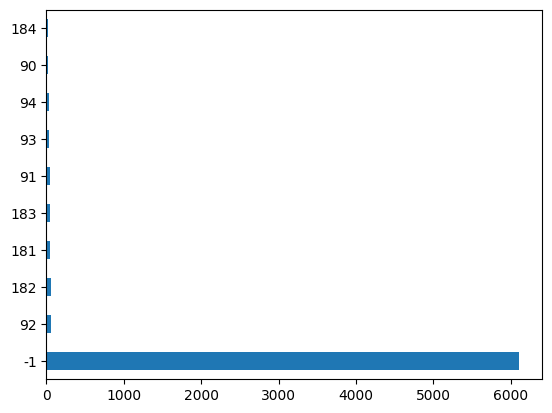

In [10]:
val_counts_days_elapsed_old = train.days_elapsed_old.value_counts()[:10].plot(kind='barh')

One can clearly see that -1 seems to be the most occuring value. As it is a days elapsed value our guess is that this data is inclompete and missing. Therefore one for sure needs to treat it as NA and impute it. Here we replace the -1 values as NA.

In [11]:
train = train.replace(-1, np.nan)
valid = valid.replace(-1, np.nan)
test = test.replace(-1, np.nan)
train.describe()

,age,time_spent,banner_views,banner_views_old,days_elapsed_old,X4
count,8056.000000,8056.000000,8056.000000,8056.000000,1952.000000,8056.000000
mean,41.175273,17.223138,2.535501,0.766013,209.152152,0.086589
std,11.671590,16.944270,2.791044,2.131492,120.399271,0.030474
min,18.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,32.000000,6.150000,1.000000,0.000000,99.000000,0.073857
50%,39.000000,11.500000,2.000000,0.000000,183.000000,0.077670
75%,49.000000,22.600000,3.000000,0.000000,300.250000,0.087779
max,95.000000,245.400000,63.000000,58.000000,854.000000,0.810043


Now the days_elapsed_old column makes more sense. We also see that the numerical data are on different scales which means that we have to standardize them. 

In [12]:
scaler = StandardScaler()
scaler.fit(train[numerical_columns_names])
train[numerical_columns_names] = pd.DataFrame(scaler.transform(train[numerical_columns_names]))
valid[numerical_columns_names] = pd.DataFrame(scaler.transform(valid[numerical_columns_names]))
test[numerical_columns_names] = pd.DataFrame(scaler.transform(test[numerical_columns_names]))

### Missing Data

As we have seen we have a lot of missig values in the categorical data and in one column of the numerical data. Therefore we need to look at the missing values. 

<Axes: >

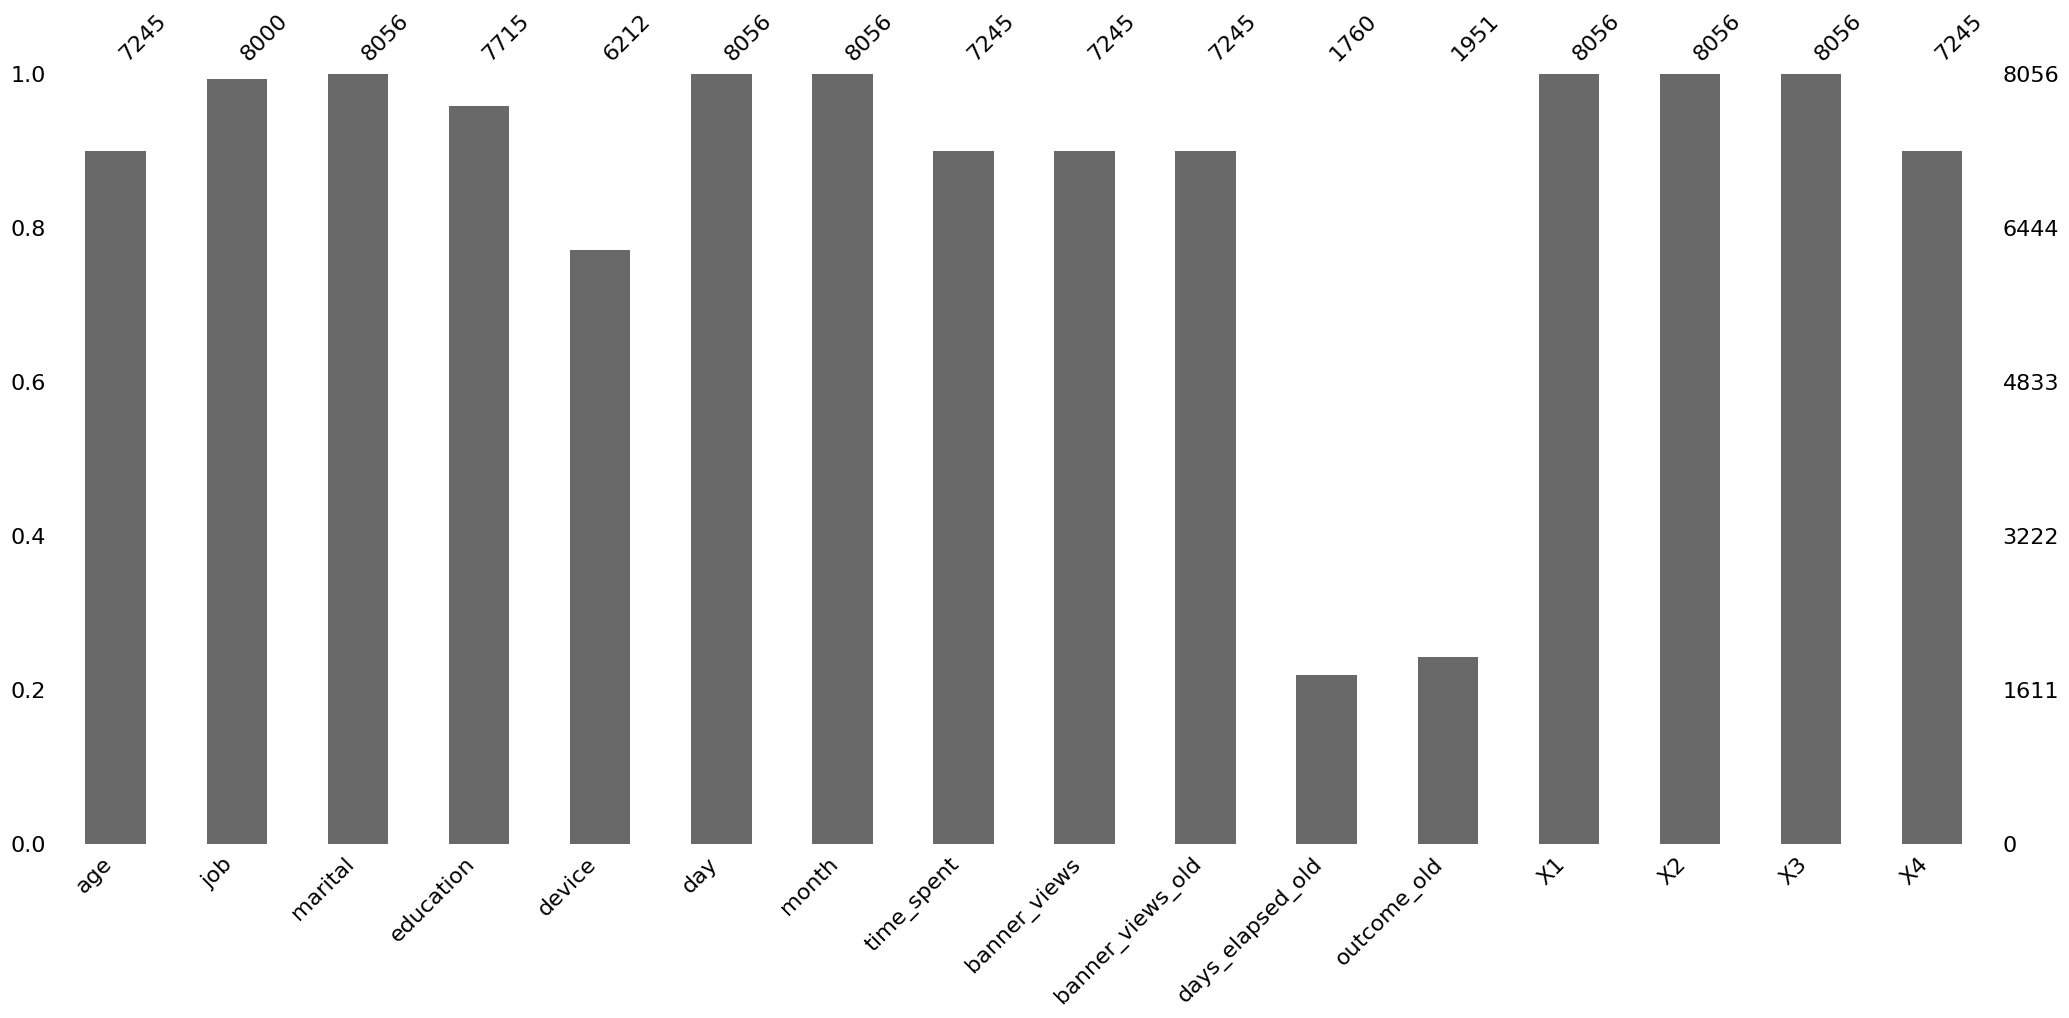

In [13]:
msno.bar(train)

It can be seen that job, education, device, outcome_old and days_elapsed_old have missing data. For the cateogrical data the values could maybe just be replaced by a missing indicator but not for the numerical data. We also see that the days_elapsed_old and outcome_old column seem to have the exact same amount of missing data. To check whether the missingness between these columns are linked we check the case whise missing data plot. 

<Axes: >

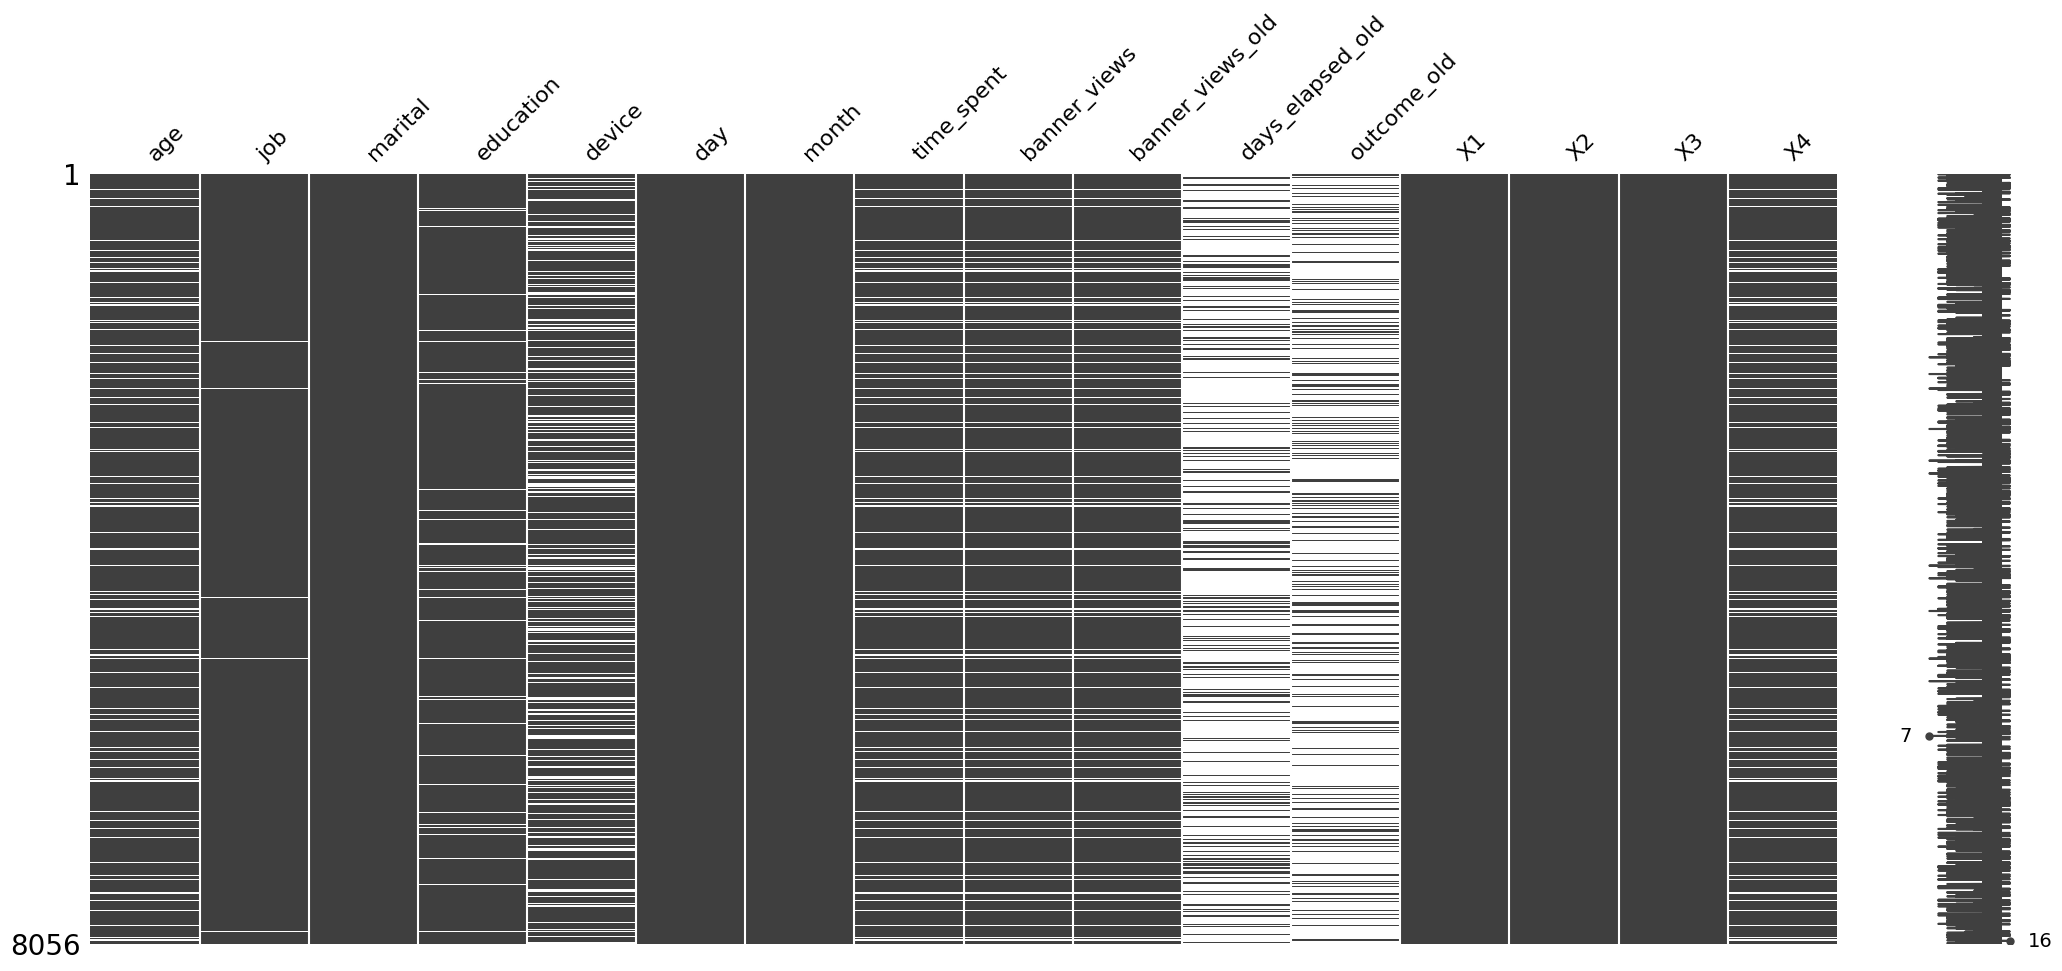

In [14]:
msno.matrix(train)

One can see on the sparkline on the right that the most missing values in a row are 5 columns that are missing and that most of the data has a value in every column.

It can be seen that days_elapsed_old and outcome_old are missing jointly. When we think about imputing these missing values we would like to use KNNImputer for the days_elapsed_old column as it would predict which value would most likely be used. But this would mean that the outcome_old would also have to be imputed with KNNImputer. This on the other hand does not work with KNNImputer as outcome_old is categorical data. What we could do is transform the categories to ordinal ones first and then fit the KNNImputer

In [15]:
# Encoding categories ordinal
enc = OrdinalEncoder()
temp1 = pd.DataFrame(enc.fit_transform(train), columns=list(train.columns))

# Imputing with KNN
imputer = KNNImputer(n_neighbors=5, weights="uniform")
temp2 = pd.DataFrame(imputer.fit_transform(temp1), columns=list(train.columns))

# Decode categories
train = pd.DataFrame(enc.inverse_transform(temp2),  columns=list(train.columns))


# Encoding categories ordinal
encvalid = OrdinalEncoder()
temp1valid = pd.DataFrame(encvalid.fit_transform(valid), columns=list(valid.columns))

# Imputing with KNN
imputervalid = KNNImputer(n_neighbors=5, weights="uniform")
temp2valid = pd.DataFrame(imputervalid.fit_transform(temp1valid), columns=list(valid.columns))

# Decode categories
valid = pd.DataFrame(encvalid.inverse_transform(temp2valid),  columns=list(valid.columns))


# Encoding categories ordinal
enctest = OrdinalEncoder()
temp1test = pd.DataFrame(enctest.fit_transform(test), columns=list(test.columns))

# Imputing with KNN
imputertest = KNNImputer(n_neighbors=5, weights="uniform")
temp2test = pd.DataFrame(imputertest.fit_transform(temp1test), columns=list(test.columns))

# Decode categories
test = pd.DataFrame(enctest.inverse_transform(temp2test),  columns=list(test.columns))

With all missing values imputed we can now do some plots to further look at the data. 

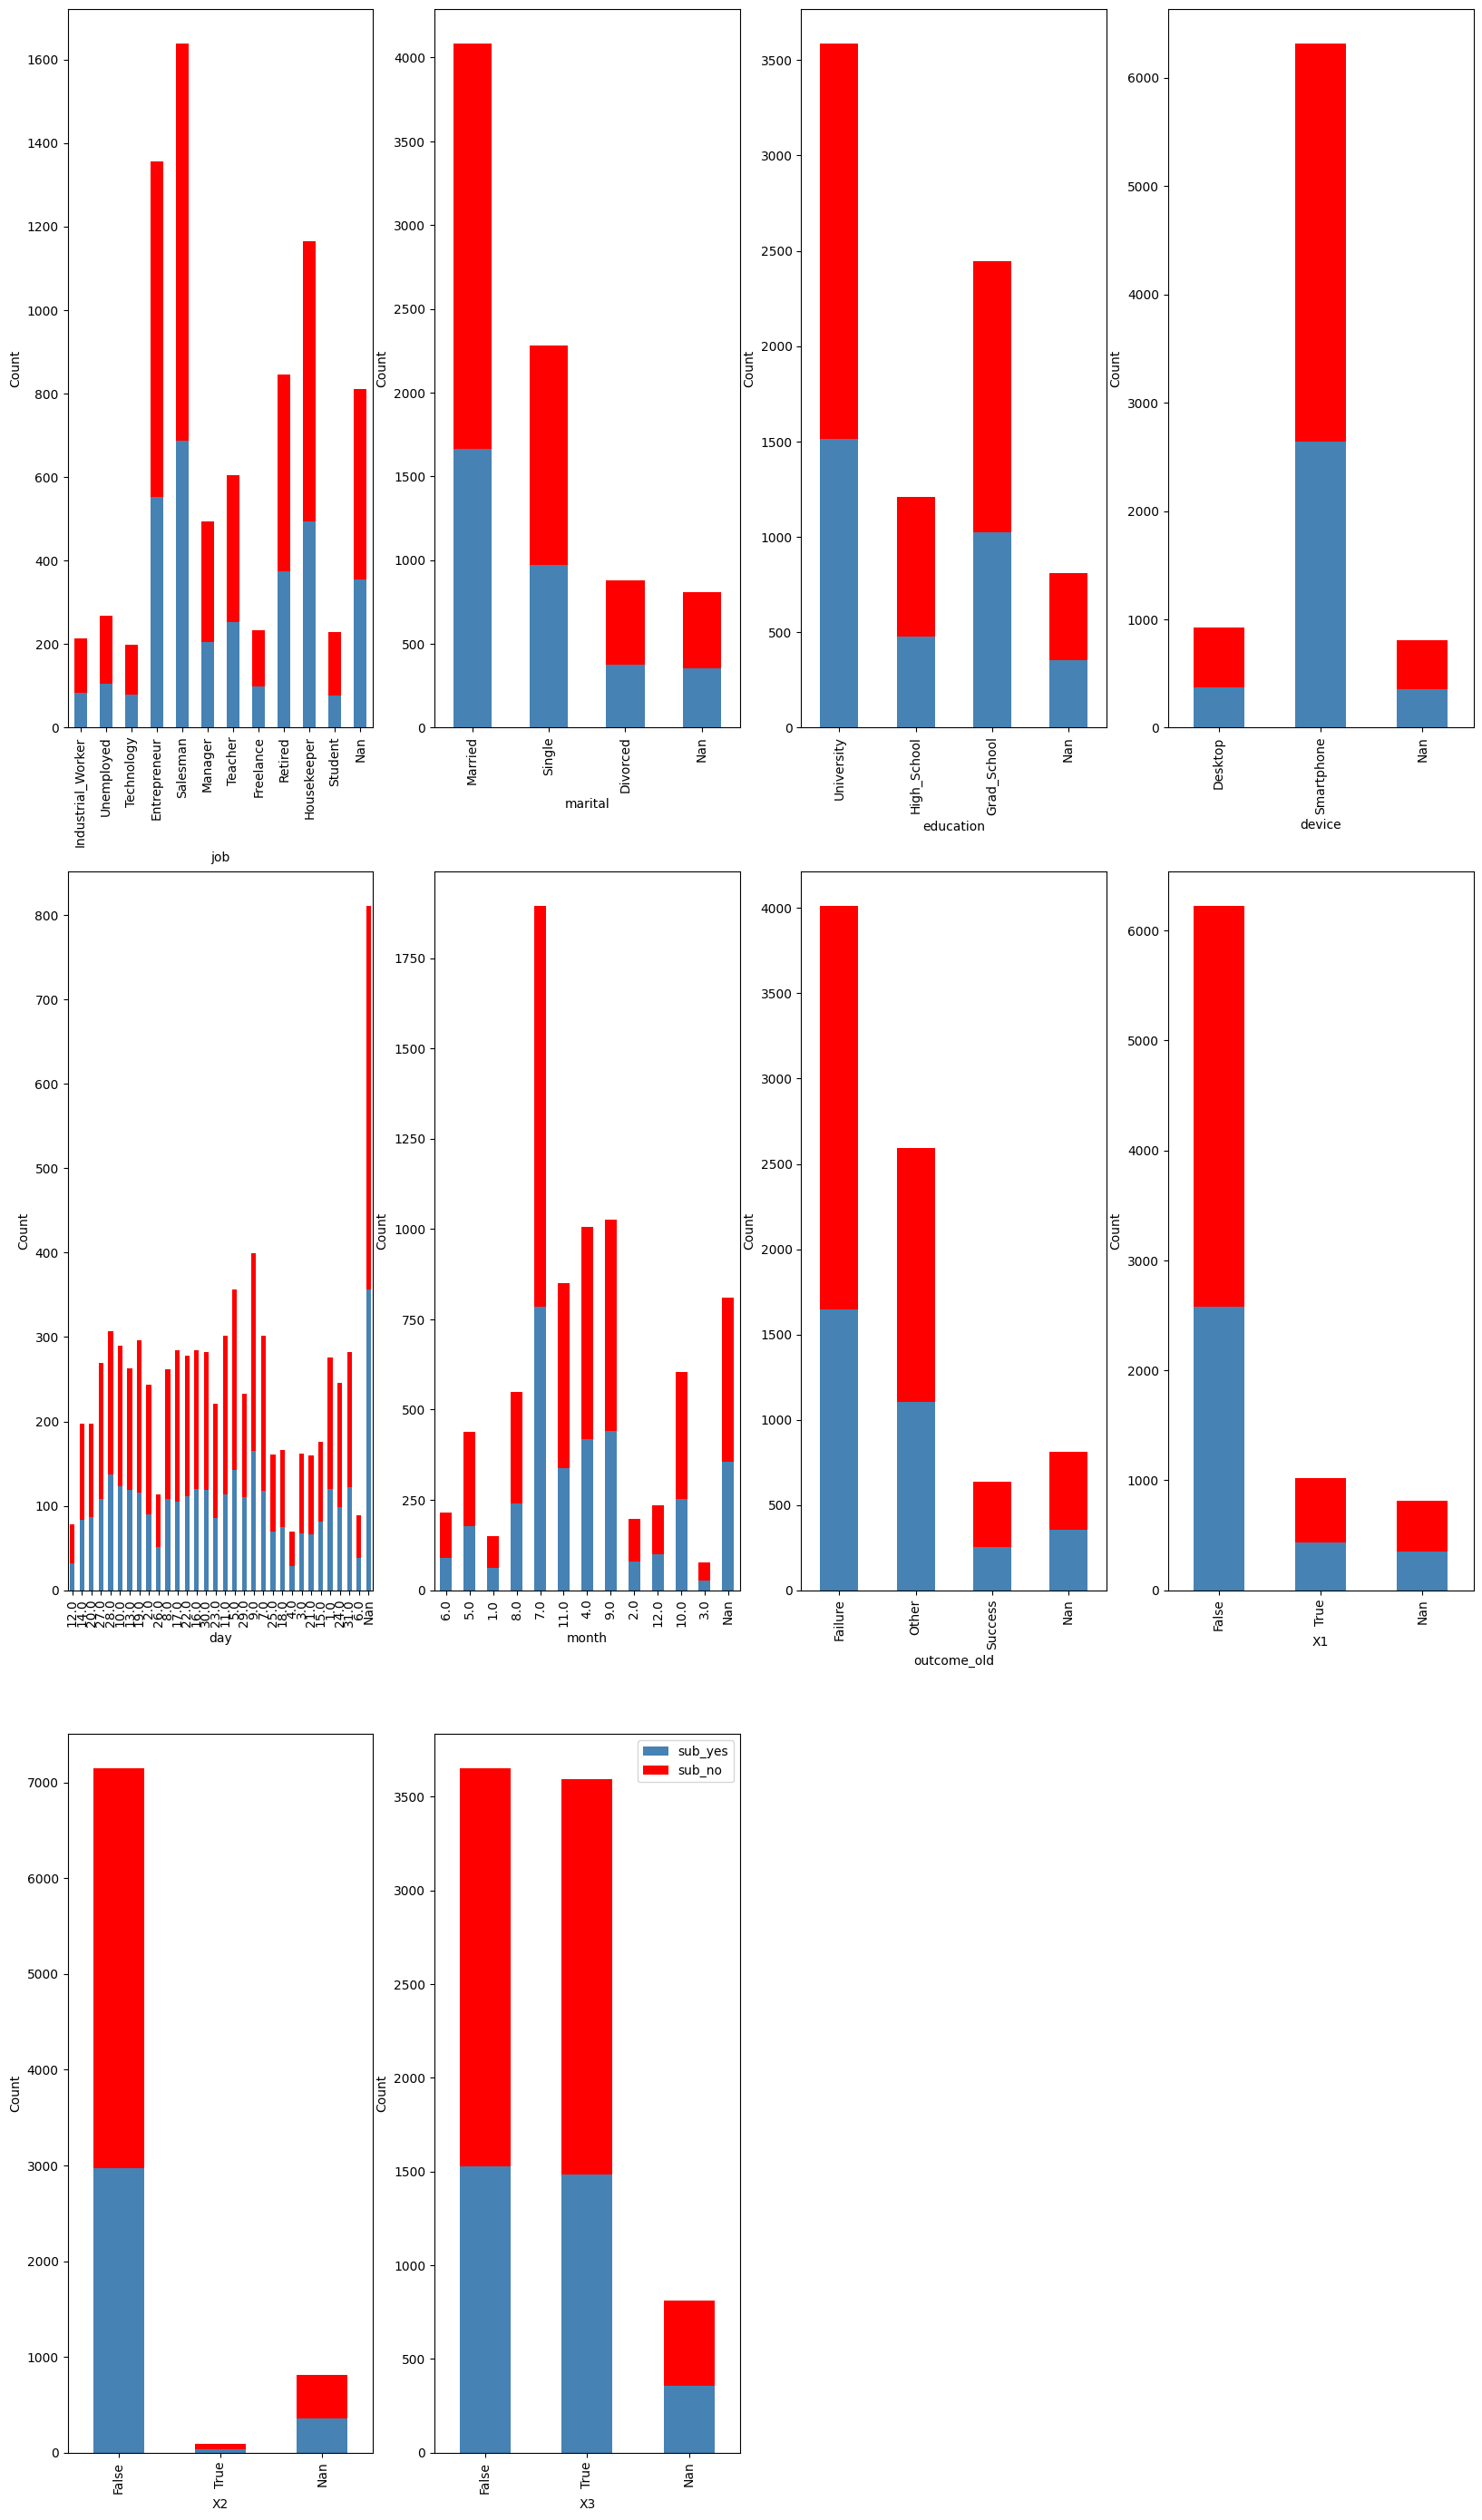

In [16]:
plt.figure(figsize=(20,35))
trainwithsub = pd.concat([train, y_train], axis=1)
for i, col in enumerate(categorical_columns_names):
    ax = plt.subplot(3, 4, i+1)
    unique_values = [str(s).title() for s in trainwithsub[col].value_counts(dropna=False, sort=False).index]
    sub_yes = trainwithsub[col][trainwithsub.subscription == True].value_counts(dropna=False, sort=False)
    sub_no = trainwithsub[col][trainwithsub.subscription == False].value_counts(dropna=False, sort=False)
    temp = pd.DataFrame({'unique':unique_values,
                         'sub_yes':sub_yes,
                         'sub_no':sub_no})
    temp.plot(kind='bar', stacked=True, color=['steelblue', 'red'], ax=ax, legend = None)
    plt.xticks(range(len(unique_values)), unique_values, rotation=90)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.legend()
plt.show()

We see that there is no clear indicator for subscription in the categorical variable. One could maybe think about scraping X2 as there are very few True values. 

Using the ordinal data from before we can also plot a correlation matrix for the whole data set (Instead of just the numerical values) and also a pairs plot for all variables. 

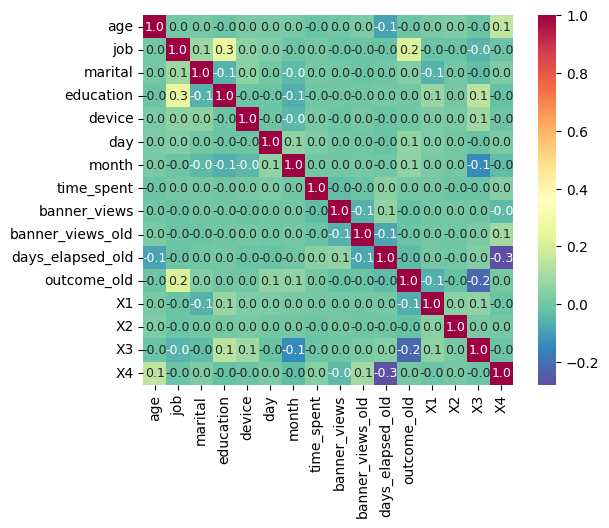

In [17]:
corrmat = temp2.corr(numeric_only=True, )
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.1f', 
                 annot_kws={'size': 9}, 
                 cmap="Spectral_r")
plt.show()

We see that there are no large correlations. The biggest one is between the categorical variable martial and age. This make sense as people who are older are more likely to be married. Simultaneously days_elapsed_old and outcome_old are correlated with -0.3 and so is days_elapsed_old with X4.

We can now also plot a pairsplot (with the ordinal data) to see the relationship between variables and to see if they are seperable when looking at subbing or not. 

In [18]:
# trainwithsub = pd.concat([temp2, y_train], axis=1)
# g = sns.PairGrid(trainwithsub, diag_sharey=False, hue='subscription')
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)

From the pairslot one can see that the Data is not easily seperable. To get better sepearability we can try squaring the data. Cubing shouldn't do anything as there are no negative values in the data. But before we do that we need to dummify the categorical data

In [19]:
train = train.astype({'X1':'int64', 'X2':'int64', 'X3':'int64', 'age':'float64', 'time_spent':'float64', 'banner_views':'float64', 'banner_views_old':'float64', 'days_elapsed_old':'float64', 'X4':'float64'})
train = pd.get_dummies(train, dummy_na=True)

valid = valid.astype({'X1':'int64', 'X2':'int64', 'X3':'int64', 'age':'float64', 'time_spent':'float64', 'banner_views':'float64', 'banner_views_old':'float64', 'days_elapsed_old':'float64', 'X4':'float64'})
valid = pd.get_dummies(valid, dummy_na=True)

test = test.astype({'X1':'int64', 'X2':'int64', 'X3':'int64', 'age':'float64', 'time_spent':'float64', 'banner_views':'float64', 'banner_views_old':'float64', 'days_elapsed_old':'float64', 'X4':'float64'})
test = pd.get_dummies(test, dummy_na=True)

/var/folders/j0/m71dtf9j0rvddgqlps9swgxc0000gn/T/ipykernel_4232/1931396889.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  train = pd.get_dummies(train, dummy_na=True)
/var/folders/j0/m71dtf9j0rvddgqlps9swgxc0000gn/T/ipykernel_4232/1931396889.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  train = pd.get_dummies(train, dummy_na=True)
/var/folders/j0/m71dtf9j0rvddgqlps9swgxc0000gn/T/ipykernel_4232/1931396889.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  valid = pd.get_dummies(valid, dummy_na=True)
/var/folders/j0/m71dtf9j0rvddgqlps9swgxc0000gn/T/ipykernel_4232/1931396889.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtyp

With the dummifyed data we can now add squared variables

In [20]:
# poly = PolynomialFeatures(2, interaction_only=False)
# poly.fit_transform(test)
# train = pd.DataFrame(poly.fit_transform(train), columns=poly.get_feature_names_out())
# test = pd.DataFrame(poly.fit_transform(test), columns=poly.get_feature_names_out())

# Square each variable in the DataFrame and add suffix to column names
train_cub = train[['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']].apply(lambda x: x**3).add_suffix('_cub')
valid_cub = valid[['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']].apply(lambda x: x**3).add_suffix('_cub')
test_cub = test[['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']].apply(lambda x: x**3).add_suffix('_cub')
train_sqd = train[['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']].apply(lambda x: x**2).add_suffix('_sqd')
valid_sqd = valid[['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']].apply(lambda x: x**2).add_suffix('_sqd')
test_sqd = test[['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']].apply(lambda x: x**2).add_suffix('_sqd')

# Add the squared variables to the original DataFrame
train = pd.concat([train, train_cub, train_sqd], axis=1)
valid = pd.concat([valid, valid_cub, valid_sqd], axis=1)
test = pd.concat([test, test_cub, test_sqd], axis=1)

## Fitting models

Here we will fit a lot of different models. 

### KNN

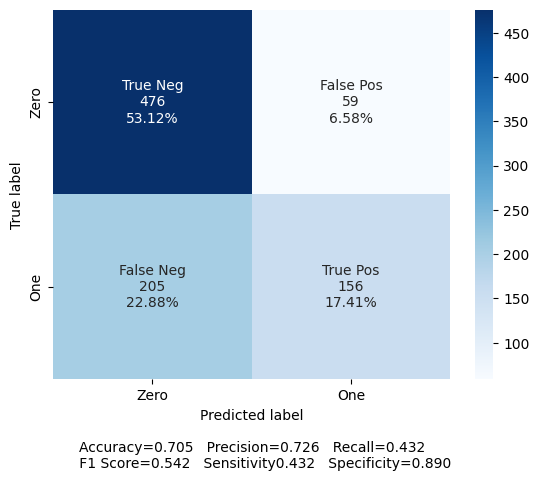

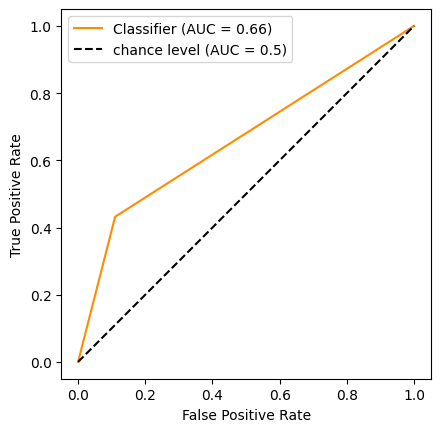

In [21]:
# Define the parameter grid for k and other hyperparameters
param_grid = {
    'n_neighbors': list(np.arange(1, 50, 25)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

# Define folds object
folds = KFold(n_splits=10 , shuffle=True, random_state=1)

# Create the KNN regressor object
knn = KNeighborsClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=folds)
grid_search.fit(train, y_train)

# extract results
results = pd.DataFrame(grid_search.cv_results_)
test_MSEs = -results["mean_test_score"]
std_test_MSEs = results["std_test_score"] / np.sqrt(grid_search.n_splits_)
parameters = results[['param_' + i for i in param_grid.keys()]]

# best parameters
index_best = np.argmin(test_MSEs) # index of the k value with the lowest MSE estimate
best_k = results.param_n_neighbors[index_best]
best_p = results.param_p[index_best]
best_w = results.param_weights[index_best]

# # one std rule
# threshold = test_MSEs[index_best] + std_test_MSEs[index_best]
# candidates = results.loc[test_MSEs <= threshold,]
# one_std_rule_index_best = np.argmax(results.mean_test_score + results.std_test_score)
# one_std_rule_best_k = results.param_n_neighbors[one_std_rule_index_best]
# one_std_rule_best_p = results.param_p[one_std_rule_index_best]
# one_std_rule_best_w = results.param_weights[one_std_rule_index_best]

# best model
best_model = KNeighborsClassifier(n_neighbors=best_k, p=best_p, weights=best_w)
best_model.fit(train, y_train)
predictions = best_model.predict(valid)
make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
plot_ROC(y_valid, predictions)

# # one std model
# one_model = KNeighborsClassifier(n_neighbors=one_std_rule_best_k, p=one_std_rule_best_p, weights=one_std_rule_best_w)
# one_model.fit(train, y_train)
# predictions = one_model.predict(valid)
# make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
# plot_ROC(y_valid, predictions)


### Ridge

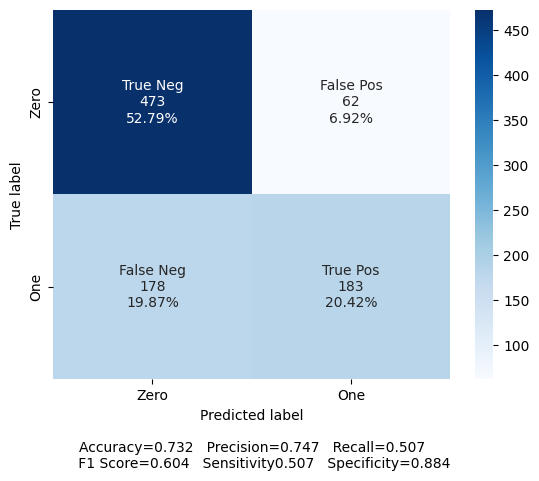

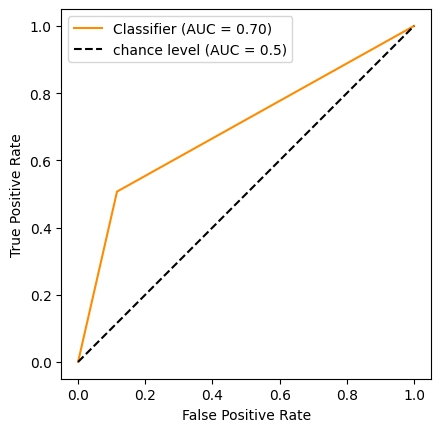

In [22]:
# Define the parameter grid for alpha
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 12.5, 15.1, 15.2, 15.3, 15.4, 15.5, 20, 25, 30, 70, 100, 150 ,1000]
}

# Define folds object
folds = KFold(n_splits=10 , shuffle=True, random_state=1)

# Create the Ridge 
ridge_reg = RidgeClassifier(fit_intercept = True)

# Create the GridSearchCV object
grid_search = GridSearchCV(ridge_reg, param_grid, cv=folds)
grid_search.fit(train, y_train)

# extract results
results = pd.DataFrame(grid_search.cv_results_)
test_MSEs = -results["mean_test_score"]
std_test_MSEs = results["std_test_score"] / np.sqrt(grid_search.n_splits_)
parameters = results[['param_' + i for i in param_grid.keys()]]

# best parameters
index_best = np.argmin(test_MSEs) # index of the k value with the lowest MSE estimate
best_alpha = results.param_alpha[index_best]

# # one std rule
# threshold = test_MSEs[index_best] + std_test_MSEs[index_best]
# candidates = results.loc[test_MSEs <= threshold,]
# one_std_rule_index_best = np.argmax(results.param_alpha)
# one_std_rule_best_alpha = results.param_alpha[one_std_rule_index_best]

# best model
best_model = RidgeClassifier(alpha= best_alpha)
best_model.fit(train, y_train)
predictions = best_model.predict(valid)
make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
plot_ROC(y_valid, predictions)

# # one std model
# one_model = RidgeClassifier(alpha=one_std_rule_best_alpha)
# one_model.fit(train, y_train)
# predictions = one_model.predict(valid)
# make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
# plot_ROC(y_valid, predictions)


### Logistic

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

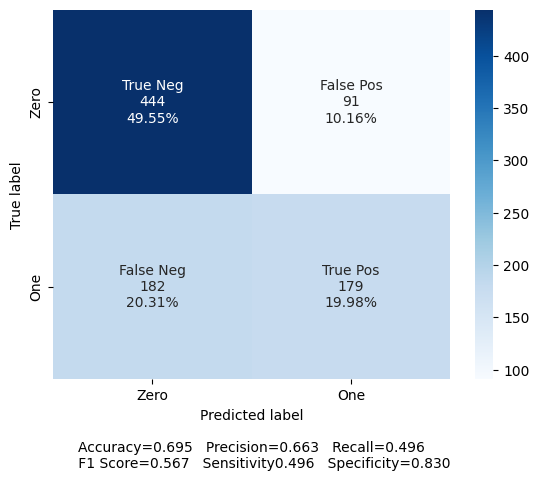

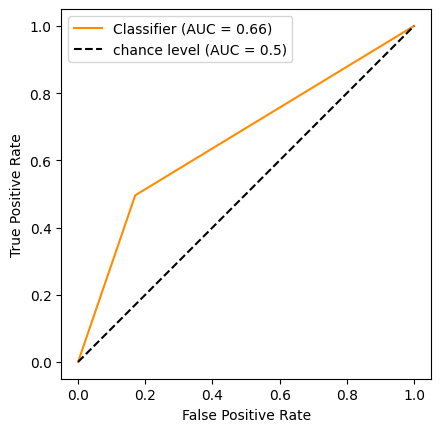

In [23]:
# Define the parameter grid for alpha
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None]
}

# Define folds object
folds = KFold(n_splits=10 , shuffle=True, random_state=1)

# Create the logistic regression 
logistic = LogisticRegression(fit_intercept = True)

# Create the GridSearchCV object
grid_search = GridSearchCV(logistic, param_grid, cv=folds)
grid_search.fit(train, y_train)

# extract results
results = pd.DataFrame(grid_search.cv_results_)
test_MSEs = -results["mean_test_score"]
std_test_MSEs = results["std_test_score"] / np.sqrt(grid_search.n_splits_)
parameters = results[['param_' + i for i in param_grid.keys()]]

# best parameters
index_best = np.argmin(test_MSEs) # index of the k value with the lowest MSE estimate
best_penalty = results.param_penalty[index_best]

# best model
best_model = LogisticRegression(penalty= best_penalty)
best_model.fit(train, y_train)
predictions = best_model.predict(valid)
make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
plot_ROC(y_valid, predictions)

### Lasso

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e+02, tolerance: 1.764e-01
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e+02, tolerance: 1.761e-01
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

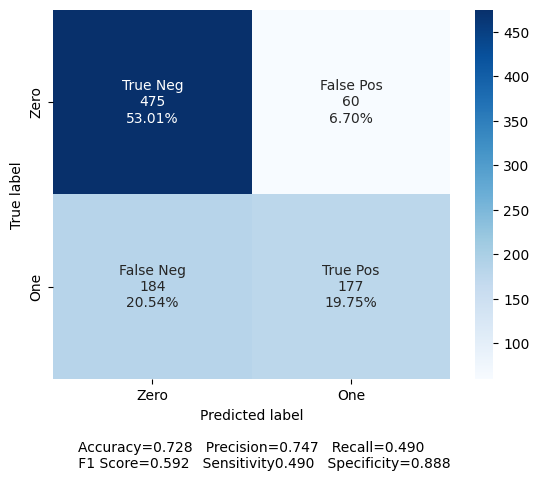

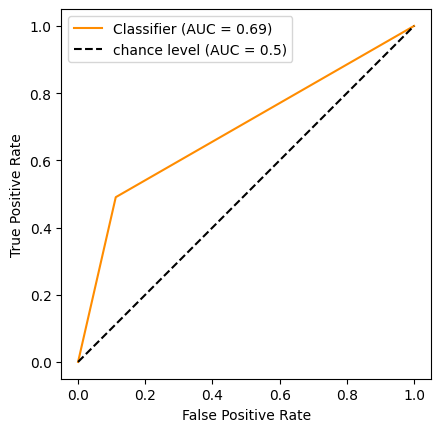

In [24]:
# Define the parameter grid for alpha
param_grid = {
    'alpha': [0.000001, 0.001, 0.01, 0.1, 1, 10, 12.5, 15.1, 15.2, 15.3, 15.4, 15.5, 20, 25, 30, 70, 100, 150 ,1000]
}

# Define folds object
folds = KFold(n_splits=10 , shuffle=True, random_state=1)

# Create the Ridge 
ridge_reg = Lasso(fit_intercept = True)

# Create the GridSearchCV object
grid_search = GridSearchCV(ridge_reg, param_grid, cv=folds)
grid_search.fit(train, y_train)

# extract results
results = pd.DataFrame(grid_search.cv_results_)
test_MSEs = -results["mean_test_score"]
std_test_MSEs = results["std_test_score"] / np.sqrt(grid_search.n_splits_)
parameters = results[['param_' + i for i in param_grid.keys()]]

# best parameters
index_best = np.argmin(test_MSEs) # index of the k value with the lowest MSE estimate
best_alpha = results.param_alpha[index_best]

# # one std rule
# threshold = test_MSEs[index_best] + std_test_MSEs[index_best]
# candidates = results.loc[test_MSEs <= threshold,]
# one_std_rule_index_best = np.argmax(results.param_alpha)
# one_std_rule_best_alpha = results.param_alpha[one_std_rule_index_best]

# best model
best_model = Lasso(alpha= best_alpha)
best_model.fit(train, y_train)
predictions = best_model.predict(valid)
predictions = [1 if i > 0.5 else 0 for i in predictions]
make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
plot_ROC(y_valid, predictions)

# # one std model
# one_model = RidgeClassifier(alpha=one_std_rule_best_alpha)
# one_model.fit(train, y_train)
# predictions = one_model.predict(valid)
# make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
# plot_ROC(y_valid, predictions)


### Decision Tree

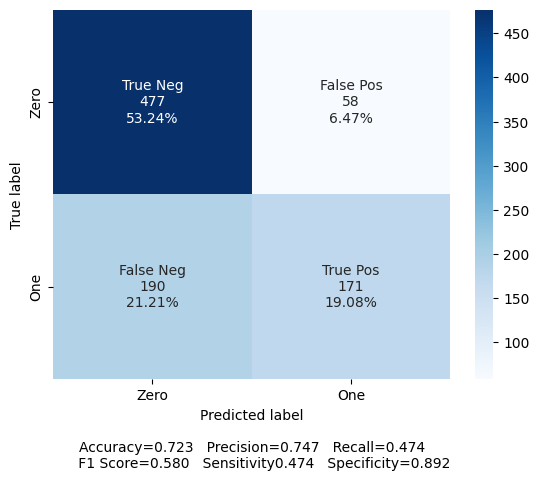

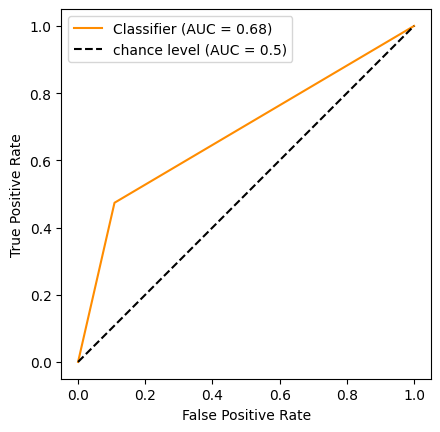

In [25]:
# fit full tree
tree_full = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, ccp_alpha=0, random_state=1)

# Define alphas as hyperparameter
path = tree_full.cost_complexity_pruning_path(train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
param_grid = {"ccp_alpha" : ccp_alphas}
param_grid = {"ccp_alpha" : [0.0001, 0.001, 0.01, 0.1]}


# Define folds object
folds = KFold(n_splits=10 , shuffle=True, random_state=1)

# Create the GridSearchCV object
grid_search = GridSearchCV(tree_full, param_grid, cv=folds)
grid_search.fit(train, y_train)

# extract results
results = pd.DataFrame(grid_search.cv_results_)
test_MSEs = -results["mean_test_score"]
std_test_MSEs = results["std_test_score"] / np.sqrt(grid_search.n_splits_)
parameters = results[['param_' + i for i in param_grid.keys()]]

# best parameters
index_best = np.argmin(test_MSEs) # index of the k value with the lowest MSE estimate
best_alpha = results.param_ccp_alpha[index_best]

# # one std rule
# threshold = test_MSEs[index_best] + std_test_MSEs[index_best]
# candidates = results.loc[test_MSEs <= threshold,]
# one_std_rule_index_best = np.argmax(results.param_alpha)
# one_std_rule_best_alpha = results.param_alpha[one_std_rule_index_best]

# best model
best_model = DecisionTreeClassifier(ccp_alpha=best_alpha, criterion='entropy', min_samples_leaf=1, random_state=1)
best_model.fit(train, y_train)
predictions = best_model.predict(valid)
predictions = [1 if i > 0.5 else 0 for i in predictions]
make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
plot_ROC(y_valid, predictions)

# # one std model
# one_model = RidgeClassifier(alpha=one_std_rule_best_alpha)
# one_model.fit(train, y_train)
# predictions = one_model.predict(valid)
# make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
# plot_ROC(y_valid, predictions)


In [26]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Define alphas as hyperparameter
from scipy.stats import uniform, randint
param_grid = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

# Define folds object
folds = KFold(n_splits=10 , shuffle=True, random_state=1)

# Create the GridSearchCV object
grid_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, random_state=42, n_iter=200, cv=folds, verbose=1, n_jobs=5, return_train_score=True)
grid_search.fit(train, y_train)

# extract results
results = pd.DataFrame(grid_search.cv_results_)
test_MSEs = -results["mean_test_score"]
std_test_MSEs = results["std_test_score"] / np.sqrt(grid_search.n_splits_)
parameters = results[['param_' + i for i in param_grid.keys()]]

# best parameters
index_best = np.argmin(test_MSEs) # index of the k value with the lowest MSE estimate
best_alpha = results.param_ccp_alpha[index_best]

# # one std rule
# threshold = test_MSEs[index_best] + std_test_MSEs[index_best]
# candidates = results.loc[test_MSEs <= threshold,]
# one_std_rule_index_best = np.argmax(results.param_alpha)
# one_std_rule_best_alpha = results.param_alpha[one_std_rule_index_best]

# best model
best_model = xgb.XGBClassifier(objective="binary:logistic", 
                               random_state=42, 
                               colsample_bytree = results.colsample_bytree[index_best],
                               gamma = results.gamma[index_best],
                               learning_rate = results.learning_rate[index_best], # default 0.1 
                               max_depth = results.max_depth[index_best], # default 3
                               n_estimators = results.n_estimators[index_best], # default 100
                               subsample = results.subsample[index_best])

best_model.fit(train, y_train)
predictions = best_model.predict(valid)
predictions = [1 if i > 0.5 else 0 for i in predictions]
make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
plot_ROC(y_valid, predictions)

# # one std model
# one_model = RidgeClassifier(alpha=one_std_rule_best_alpha)
# one_model.fit(train, y_train)
# predictions = one_model.predict(valid)
# make_confusion_matrix(confusion_matrix(y_valid, predictions), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'])
# plot_ROC(y_valid, predictions)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


KeyboardInterrupt: 

KAGGLE 

In [28]:
# Make predictions
y_test_pred = best_model.predict(test)

# Test Shape
print(y_test_pred)
y_test_pred.shape

# To Dataframe
Predictions_On_Test = pd.DataFrame({'subscription': y_test_pred}).reset_index()

Predictions_On_Test = Predictions_On_Test.rename(columns={Predictions_On_Test.columns[0]: 'Id'})

# To CSV
pd.DataFrame(Predictions_On_Test).to_csv("Predictions_On_Test.csv",index=False)

# Print
print(y_test_pred.shape)

[0 1 0 ... 0 1 1]
(3837,)
